In [ ]:
import random
import numpy as np
import torch

EPOCHS = 50

# ============================================================
# 1. 啟用多核心加速 (要在最前面呼叫)
# ============================================================
torch.set_num_threads(torch.get_num_threads())
print("使用 CPU threads:", torch.get_num_threads())

# ============================================================
# 2. 固定隨機種子 (PyTorch / NumPy / Python random)
# ============================================================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# cudnn 設定 (確保結果完全可重現，但可能會稍微變慢)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
# 3. 裝置設定 (CPU / GPU)
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用裝置:", device)



使用 CPU threads: 16
使用裝置: cpu


# Variational Autoencoder (VAE) 邏輯流程

---

## 1. 問題背景
- **Autoencoder (AE)**：輸入 → Encoder → Decoder → 重建輸出。  
- **限制**：Latent space 缺乏機率結構，難以生成新樣本。  
- **VAE 目標**：
  - 將輸入影像映射到一個**機率分布**（均值 $\mu$、變異數 $\sigma^2$）。  
  - 建立規範化的 latent space，支持生成新資料。  

---

## 2. 資料流與維度

- **輸入**：MNIST 圖片 $x$，形狀 $(B, 1, 28, 28)$  
- **展平**：$(B, 784)$  

### Encoder
- $(B, 784) \;\to\; (B, h\_dim)$  
- 兩個輸出：
  - $\mu = fc21(h) \;\;\;(B, z\_dim)$  
  - $\text{logvar} = fc22(h) \;\;\;(B, z\_dim)$  

### Reparameterization
- $\sigma = \exp \left( \tfrac{1}{2} \cdot \text{logvar} \right)$  
- $\epsilon \sim \mathcal{N}(0, I)$  
- $z = \mu + \sigma \cdot \epsilon$  
- 結果形狀 $(B, z\_dim)$  

### Decoder
- $(B, z\_dim) \;\to\; (B, h\_dim) \;\to\; (B, 784)$  
- reshape → $(B, 1, 28, 28)$  
- **輸出範圍可以有兩種作法**：  
  1. **Sigmoid → [0,1]**：適合影像本來就在 [0,1]  
  2. **Tanh → [-1,1]**：常用於生成模型 (GAN, Diffusion)，需要將影像預處理到 [-1,1]  
---

## 3. 損失函數

### Reconstruction Loss

#### 若輸出在 `[0,1]`
- 重建誤差：使用 **Binary Cross Entropy (BCE)**  
$$
\text{BCE}(x, \hat{x}) = -\sum \big[ x \log \hat{x} + (1-x)\log(1-\hat{x}) \big]
$$

#### 若輸出在 `[-1,1]`
- 重建誤差：常用 **MSE (Mean Squared Error)**  
$$
\text{MSE}(x, \hat{x}) = \sum (x - \hat{x})^2
$$

### KL Divergence
- 讓近似後驗分布 $q(z|x)$ 接近標準常態 $p(z) = \mathcal{N}(0, I)$：  
$$
\text{KL}(q(z|x) \parallel p(z))
= -\tfrac{1}{2} \sum \left( 1 + \text{logvar} - \mu^2 - \exp(\text{logvar}) \right)
$$

### 總損失
$$
L = \text{Reconstruction} + \text{KL}
$$

---

## 4. 訓練步驟（每個 batch）

1. **前向傳遞**  
   - $\mu, \text{logvar} = \text{Encoder}(x)$  
   - $z = \text{reparameterize}(\mu, \text{logvar})$  
   - $\hat{x} = \text{Decoder}(z)$  

2. **計算損失**  
   - 若輸出 `[0,1]` → 用 BCE  
   - 若輸出 `[-1,1]` → 用 MSE
   - 加上 $\text{KL}(\mu, \text{logvar})$  

3. **反向傳遞與更新**  
   - $loss = \text{Reconstruction} + \text{KL}$  
   - $loss.\text{backward()}$  
   - $optimizer.\text{step()}$  

---

## 5. 程式碼對應

- **fc21, fc22** → Encoder 兩個輸出頭，分別計算 $\mu$、logvar  
- **reparameterize()** → 將 $(\mu, \text{logvar})$ 轉為 $z$  
- **vae_loss()** → 計算 BCE + KL  
- **forward()** → 串接完整流程  

---

## 6. 整體邏輯摘要

- **Encoder**：學習輸入的分布參數 $(\mu, \text{logvar})$  
- **Reparameterization**：利用 reparameterization trick，生成可微分的 latent 向量 $z$  
- **Decoder**：由 latent 向量 $z$ 重建輸入  
- **Loss**：$\text{Reconstruction} + \text{KL}$，其中  
  - **若資料/輸出在 `[0,1]`**：`Decoder=Sigmoid`，`Reconstruction=BCE`  
  - **若資料/輸出在 `[-1,1]`**：`Decoder=Tanh`，`Reconstruction=MSE`  
- **最終結果**：模型既能重建輸入，又能透過 latent 空間生成新影像


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 數據預處理

# Decoder 輸出經 Sigmoid 壓到 [0,1]
transform = transforms.ToTensor()

# Decoder 輸出經 Tanh 壓到 [-1,1]
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


batch_size = 128

# 下載 MNIST 數據集
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

x_train = train_dataset.data    # 圖片
y_train = train_dataset.targets # 標籤
print(f'x_train size: {x_train.size()}')
print(f'y_train size: {y_train.size()}')


x_test = test_dataset.data    # 圖片
y_test = test_dataset.targets # 標籤
print(f'x_test size: {x_test.size()}')
print(f'y_test size: {y_test.size()}')

x_train size: torch.Size([60000, 28, 28])
y_train size: torch.Size([60000])
x_test size: torch.Size([10000, 28, 28])
y_test size: torch.Size([10000])


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image


# =============================
# 1. 定義 VAE 模型
# =============================

class VAE(nn.Module):
    def __init__(self, z_dim=20, h_dim=400):
        super().__init__()

        self.z_dim = z_dim
        self.h_dim = h_dim

        # Encoder：把輸入的 784 維影像壓縮
        self.fc1  = nn.Linear(28 * 28, h_dim)   # (784 → h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)     # (h_dim → z_dim) 輸出 μ
        self.fc22 = nn.Linear(h_dim, z_dim)     # (h_dim → z_dim) 輸出 logσ²

        # Decoder：把 z 還原回 784 維影像
        self.fc3  = nn.Linear(z_dim, h_dim)     # (z_dim → h_dim)
        self.fc4  = nn.Linear(h_dim, 28 * 28)   # (h_dim → 784)

    def encode(self, x):
        # x: (B, 784)；先過一層非線性取表徵 h
        h = torch.relu(self.fc1(x))

        # 以同一個 h，各自經過不同線性層，得到 μ 與 logσ²
        # 兩個 head 結構相同，但權重獨立 → 能輸出不同值
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        # 重參數化：z = μ + σ * ε，其中 σ = exp(0.5 * logσ²)
        std = torch.exp(0.5 * logvar)

        # 逐元素抽樣 ε ~ N(0,1)，形狀同 std
        eps = torch.randn_like(std)

        # 這個寫法讓 z 對 μ、logvar 可微，有助反傳更新 Encoder
        return mu + eps * std

    def decode(self, z):
        # 先把 z 投影回隱藏層，再輸出 784 維的重建向量
        h = torch.relu(self.fc3(z))

        # 用 sigmoid 壓到 [0,1]，對應像素機率/強度
        return torch.sigmoid(self.fc4(h))   # → (B, 784) in [0,1]

    def forward(self, x):
        # 接受影像 (B,1,28,28) 或 (B,28,28)，統一攤平成 (B,784)
        x = x.view(-1, 28 * 28)

        # 編碼：得到 q(z|x) 的參數 μ 與 logσ²
        mu, logvar = self.encode(x)

        # 取樣潛變量 z（可微）
        z = self.reparameterize(mu, logvar)

        # 解碼：得到重建 hat{x}（仍是 (B,784)）
        x_hat = self.decode(z)

        # 回傳重建與參數，供 loss 使用
        return x_hat, mu, logvar


# =============================
# 2. 定義 Loss 函數
# =============================

def vae_loss(recon_x, x, mu, logvar):
    # 與 forward 一致，確保 x 與 recon_x 形狀相同
    x = x.view(-1, 28 * 28)

    # 使用 BCE 當重建誤差：
    # - 對每個像素計算交叉熵 (假設像素值為 [0,1] 的機率分布)
    # - "sum" 代表先把整個 batch 的所有像素誤差加總
    # - 再除以 batch 大小，換算成「每張圖平均的總誤差」
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum") / x.size(0)

    # KL：讓 q(z|x) 靠近 N(0,I)
    # -0.5 * Σ (1 + logσ² - μ² - σ²)，再除 batch 成每樣本平均
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    # 同時回傳三個：總 loss / BCE / KLD，方便監控
    return BCE + KLD, BCE, KLD


# =============================
# 3. 初始化模型與設定
# =============================

vae = VAE(z_dim=20, h_dim=512).to(device)
opt_vae = optim.Adam(vae.parameters(), lr=1e-3)

os.makedirs("samples/vae", exist_ok=True)


# =============================
# 4. 訓練流程
# =============================

def train_vae(epochs=5):
    # 切到訓練模式（啟用 dropout/bn 等行為；這裡主要是慣例）
    vae.train()

    # 固定一組 z，方便每個 epoch 後觀察生成圖片的變化
    fixed_z = torch.randn(10, vae.z_dim).to(device)

    for epoch in range(1, epochs + 1):
        total_loss, total_bse, total_kld = 0.0, 0.0, 0.0

        for x, _ in train_loader:  # train_loader 需事先準備好，x ∈ [-1,1] / x ∈ [0,1]
            # 批次讀資料，搬到 CPU/GPU
            x = x.to(device)       # (B,1,28,28)

            # 前向：拿到重建、μ、logσ²
            x_hat, mu, logvar = vae(x)

            # 計算 Loss（會同時得到 BCE 與 KLD）
            loss, bse, kld = vae_loss(x_hat, x, mu, logvar)

            # 典型訓練三步驟：清梯度 → 反傳 → 更新
            opt_vae.zero_grad()
            loss.backward()
            opt_vae.step()

            # 注意：此處的 loss 已經是「每 batch 的平均到每樣本的 loss」
            total_loss += loss.item()
            total_bse += bse.item()
            total_kld += kld.item()

        # 計算平均損失
        loss_avg = total_loss / len(train_loader)
        bse_avg = total_bse / len(train_loader)
        kld_avg = total_kld / len(train_loader)

        print(f"[VAE] Epoch {epoch}, Loss={loss_avg:.4f} | BSE: {bse_avg:.4f} | KLD: {kld_avg:.4f}")

        save_vae_samples(epoch, fixed_z)  # 每個 epoch 存圖


# =============================
# 5. 儲存生成樣本
# =============================

@torch.no_grad()
def save_vae_samples(epoch, fixed_z):
    # 評估模式（關閉 dropout 等），與 no_grad() 一起讓推論更快
    vae.eval()

    # 還原成影像維度
    samples = vae.decode(fixed_z).view(-1, 1, 28, 28)

    save_image(samples, f"samples/vae/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

    print(f"已儲存 samples/vae/epoch_{epoch}.png")


# =============================
# 6. 執行訓練
# =============================

if __name__ == "__main__":
    train_vae(epochs=EPOCHS)
    print("VAE 訓練完成！")


[VAE] Epoch 1, Loss=160.3311 | BSE: 144.5981 | KLD: 15.7330
已儲存 samples/vae/epoch_1.png
[VAE] Epoch 2, Loss=119.2050 | BSE: 96.5330 | KLD: 22.6720
已儲存 samples/vae/epoch_2.png
[VAE] Epoch 3, Loss=113.0470 | BSE: 88.9354 | KLD: 24.1116
已儲存 samples/vae/epoch_3.png
[VAE] Epoch 4, Loss=110.4188 | BSE: 85.7592 | KLD: 24.6596
已儲存 samples/vae/epoch_4.png
[VAE] Epoch 5, Loss=108.8125 | BSE: 83.8895 | KLD: 24.9230
已儲存 samples/vae/epoch_5.png
[VAE] Epoch 6, Loss=107.7879 | BSE: 82.6834 | KLD: 25.1045
已儲存 samples/vae/epoch_6.png
[VAE] Epoch 7, Loss=106.9846 | BSE: 81.7953 | KLD: 25.1893
已儲存 samples/vae/epoch_7.png
[VAE] Epoch 8, Loss=106.3808 | BSE: 81.1232 | KLD: 25.2576
已儲存 samples/vae/epoch_8.png
[VAE] Epoch 9, Loss=105.9092 | BSE: 80.5558 | KLD: 25.3535
已儲存 samples/vae/epoch_9.png
[VAE] Epoch 10, Loss=105.4816 | BSE: 80.1164 | KLD: 25.3653
已儲存 samples/vae/epoch_10.png
[VAE] Epoch 11, Loss=105.1318 | BSE: 79.7236 | KLD: 25.4082
已儲存 samples/vae/epoch_11.png
[VAE] Epoch 12, Loss=104.8643 | BSE: 7

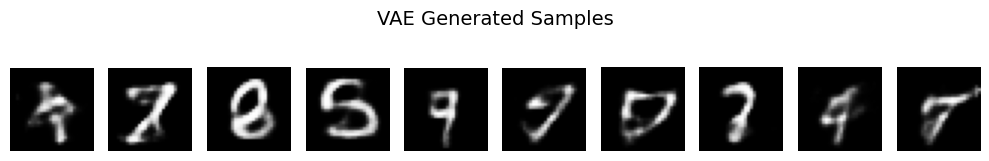

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_vae_samples(n=10):
    vae.eval()

    # 固定隨機噪聲 z
    z = torch.randn(n, vae.z_dim).to(device)

    # 解碼成影像
    samples = vae.decode(z).view(-1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    for i in range(n):
        axes[i].imshow(samples[i], cmap="gray")
        axes[i].axis("off")

    # ✅ 設定大標題，置中顯示
    plt.suptitle("VAE Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


show_vae_samples()

# Generative Adversarial Network (GAN) 邏輯流程

---

## 1. 問題背景
- **核心概念**：GAN 是一種「對抗式學習」模型，包含兩個網路：
  - **生成器 (Generator, G)**：從隨機噪聲中生成假樣本。
  - **鑑別器 (Discriminator, D)**：判斷輸入樣本是真的 (來自資料集) 還是假的 (來自 G)。
- **訓練過程**：  
  - G 嘗試騙過 D → 生成看起來更逼真的假資料。  
  - D 嘗試分辨真偽 → 讓自己判斷更準確。  
- **最後達成**：**納許均衡 (Nash equilibrium)** → G 生成的樣本幾乎和真實資料分布一樣，D 分不出差別。

---

## 2. 資料流與維度 (以 MNIST 28×28 為例)

### 生成器 G
- 輸入：隨機向量 $z \sim \mathcal{N}(0,I)$，形狀 $(B, z\_dim, 1, 1)$  
- **層級結構：**
  - **第一層 ConvTranspose2d**
    ```python
    nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0)
    ```
    - 輸入大小：$(B, z\_dim, 1, 1)$
    - 計算公式：
      $$
      H_{out} = (H_{in} - 1) \times stride - 2 \times padding + kernel\_size
      $$
      代入：$H_{in}=1,\ stride=1,\ padding=0,\ kernel=7$
      $$
      H_{out} = (1-1)\times 1 - 0 + 7 = 7
      $$
    - 輸出大小：$(B,128,7,7)$
  - **第二層 ConvTranspose2d**
    ```python
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
    ```
    - 輸入大小：$(B,128,7,7)$
    - 代入公式：$H_{in}=7,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = (7-1)\times 2 - 2 + 4 = 14
      $$
    - 輸出大小：$(B,64,14,14)$
  - **第三層 ConvTranspose2d**
    ```python
    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
    ```
    - 輸入大小：$(B,64,14,14)$
    - 代入公式：$H_{in}=14,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = (14-1)\times 2 - 2 + 4 = 28
      $$
    - 輸出大小：$(B,1,28,28)$
- **最後輸出激活**：
  - **Tanh** → 範圍 $[-1,1]$（常用於 DCGAN）
  - **Sigmoid** → 範圍 $[0,1]$（若輸入資料是歸一化到 [0,1]）

---

### 鑑別器 D
- 輸入：影像 $(B,1,28,28)$
- **層級結構：**
  - **第一層 Conv2d**
    ```python
    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
    ```
    - 輸入大小：$(B,1,28,28)$
    - 計算公式：
      $$
      H_{out} = \frac{H_{in} + 2\times padding - kernel\_size}{stride} + 1
      $$
      代入：$H_{in}=28,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = \frac{28+2-4}{2}+1 = 14
      $$
    - 輸出大小：$(B,64,14,14)$
  - **第二層 Conv2d**
    ```python
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    ```
    - 輸入大小：$(B,64,14,14)$
    - 代入：$H_{in}=14,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = \frac{14+2-4}{2}+1 = 7
      $$
    - 輸出大小：$(B,128,7,7)$
  - **第三層 Conv2d**
    ```python
    nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0)
    ```
    - 輸入大小：$(B,128,7,7)$
    - 代入：$H_{in}=7,\ stride=1,\ padding=0,\ kernel=7$
      $$
      H_{out} = \frac{7+0-7}{1}+1 = 1
      $$
    - 輸出大小：$(B,1,1,1)$ → 再壓平成 $(B,1)$
- **最後輸出激活**：
  - **Sigmoid**，結果 $\in [0,1]$，代表「真實的機率」。

---

## 3. 損失函數 (對抗式目標)

### 對鑑別器 D
- 希望對真實樣本輸出 1、對假樣本輸出 0。
- 損失：
  $$
  L_D = -\frac{1}{2} \Big[ \log D(x_{real}) + \log (1 - D(x_{fake})) \Big]
  $$

### 對生成器 G
- 希望生成的假樣本能騙過 D，被判斷為真。
- 損失：
  $$
  L_G = - \log D(x_{fake})
  $$

---

## 4. 訓練步驟（每個 batch）
- **訓練 D**
  - 從資料集中取一批真樣本，標籤設為 1。
  - 用 G 生成一批假樣本，標籤設為 0。
  - 用 BCE Loss 分別計算誤差，更新 D 的參數。
- **訓練 G**
  - 重新取一批噪聲 $z$，生成假樣本。
  - 餵進 D，期望 D 的輸出接近 1 (被騙)。
  - 用 BCE Loss 更新 G 的參數。

---

## 5. 程式碼對應 (核心對照)
- Generator 類別 → 定義反捲積結構，把 $z$ 變成 28×28 影像。
- Discriminator 類別 → 定義卷積結構，輸入影像輸出真偽機率。
- optG / optD → 分別更新 G 和 D 的最佳化器 (Adam)。
- criterion：
  - `nn.BCELoss()` → 需要 D 輸出經過 **Sigmoid**（範圍 [0,1]）。
  - `nn.BCEWithLogitsLoss()` → D 輸出 raw logit，不需顯式加 Sigmoid，更穩定。
- 訓練流程：
  - `lossD_real = criterion(D(x_real), label_real)`
  - `lossD_fake = criterion(D(x_fake.detach()), label_fake)`
  - `lossG = criterion(D(x_fake), label_real)`

---

## 6. 訓練觀察
- **LossD**
  - 太低 → D 判斷太準，G 很難學。
  - 太高 → D 被騙得太慘，可能 G collapse。
- **LossG**
  - 太高 → G 無法騙過 D，生成不真實。
  - 適中 → G 和 D 拉鋸，代表對抗健康。
- **常見技巧**
  - Label smoothing：真樣本標籤由 1 改成 0.9（或隨機在 [0.8,1.0]），避免 D 過於強大。
  - BCEWithLogitsLoss：建議取代 BCELoss，數值更穩定。
  - 固定 latent 向量：每個 epoch 用同一組 $z$，輸出圖片方便觀察 G 的學習情況。

---

## 7. 整體邏輯摘要
- Generator (G)：噪聲 → 假圖片。
- Discriminator (D)：圖片 → 真或假。
- 對抗式訓練：
  - D 學會判斷真假。
  - G 學會騙過 D。
- 最終目標：生成器 G 產生的影像和真實資料分布幾乎一致。


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# =============================
# 1. 定義 GAN 模型
# =============================

class Generator(nn.Module):
    """
    生成器 (G)：將隨機噪聲 z 轉換成看似真實的圖片。
    - 使用 ConvTranspose2d (反卷積/轉置卷積) 逐步放大 z 的空間維度。
    - 最後輸出一張 28x28 的灰階圖片 (MNIST)。
    """
    def __init__(self, z_dim=100, img_channels=1):
        super().__init__()

        self.z_dim = z_dim

        self.net = nn.Sequential(
            # 輸入 latent vector (B, z_dim, 1, 1) → (B,128,7,7)
            # kernel=7, stride=1, padding=0
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            # BatchNorm2d：標準化每個 batch 的特徵分布 → 訓練更穩定，加快收斂
            nn.BatchNorm2d(128),
            # ReLU：非線性激活，讓生成器能學習複雜映射，把噪聲轉換成影像特徵
            nn.ReLU(True),

            # (B,128,7,7) → (B,64,14,14)
            # kernel=4, stride=2, padding=1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # (B,64,14,14) → (B,1,28,28)
            # 輸出與 MNIST 圖片大小相同
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            # 將像素壓到 [0,1]（因為 MNIST 是 [0,1]），如果輸入資料是 [-1,1]，會改成 Tanh()
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    """
    鑑別器 (D)：判斷輸入圖片是真 (1) 還是假 (0)。
    - 使用 Conv2d (卷積) 逐步壓縮圖片空間維度。
    - 最後輸出一個標量，代表「真實機率」。
    """
    def __init__(self, img_channels=1):
        super().__init__()

        self.net = nn.Sequential(
            # (B,1,28,28) → (B,64,14,14)
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # LeakyReLU：允許 x<0 時仍有微小梯度，避免 ReLU「死掉」，更適合判別器
            nn.LeakyReLU(0.2, inplace=True),

            # (B,64,14,14) → (B,128,7,7)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # BatchNorm2d：避免鑑別器因輸入差異太大而不穩
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,128,7,7) → (B,1,1,1)
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            # 輸出 ∈ [0,1]，代表「真實機率」
            nn.Sigmoid()
        )

    def forward(self, x):
        # 壓平成 (B,) 向量，每張圖輸出一個數字
        return self.net(x).view(-1)


# =============================
# 2. 初始化模型與設定
# =============================

# z_dim latent 向量維度 (輸入生成器的噪聲大小)

# 建立 G 和 D
G_1 = Generator(z_dim=100).to(device)
D_1 = Discriminator().to(device)

# Adam：常見 GAN 最佳化器 (beta 設為 0.5, 0.999 避免震盪)
g_opt = optim.Adam(G_1.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = optim.Adam(D_1.parameters(), lr=2e-4, betas=(0.5, 0.999))

# 損失函數：BCE
criterion = nn.BCELoss()

os.makedirs("samples/gan", exist_ok=True)


# =============================
# 3. 訓練流程
# =============================

def train_gan(epochs=5):
    # 固定噪聲，用於每個 epoch 的觀察圖
    fixed_z = torch.randn(10, G_1.z_dim, 1, 1, device=device)

    for epoch in range(1, epochs + 1):
        # 因為有 BatchNorm → 每個 epoch 都要重設。
        G_1.train()
        D_1.train()

        total_d_loss, total_g_loss = 0.0, 0.0

        for x, _ in train_loader:
            x = x.to(device)  # (B,1,28,28)

            current_batch_size = x.size(0)
            real_labels = torch.ones(current_batch_size, device=device)   # 真實樣本標籤=1
            fake_labels = torch.zeros(current_batch_size, device=device)  # 假樣本標籤=0

            # --------- 訓練 D ---------
            # step1: 真實樣本
            d_loss_real = criterion(D_1(x), real_labels)

            # step2: 假樣本 (由 G 生成，detach 以免更新 G)
            z = torch.randn(current_batch_size, G_1.z_dim, 1, 1, device=device)
            fake = G_1(z)
            d_loss_fake = criterion(D_1(fake.detach()), fake_labels)

            # D 的總損失 = 真實 + 假 的平均
            d_loss = (d_loss_real + d_loss_fake) / 2

            # 典型訓練三步驟：清梯度 → 反傳 → 更新
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # --------- 訓練 G ---------
            # 希望 D(fake)=1 (騙過鑑別器)
            z = torch.randn(current_batch_size, G_1.z_dim, 1, 1, device=device)
            fake = G_1(z)
            g_loss = criterion(D_1(fake), real_labels)

            # 典型訓練三步驟：清梯度 → 反傳 → 更新
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            # 累加損失
            total_d_loss += d_loss.item() * current_batch_size
            total_g_loss += g_loss.item() * current_batch_size

        # 計算平均損失
        d_avg = total_d_loss / len(train_loader.dataset)
        g_avg = total_g_loss / len(train_loader.dataset)

        print(f"[GAN] Epoch {epoch}, LossD={d_avg:.4f} | LossG={g_avg:.4f}")

        # 每個 epoch 儲存生成圖片
        save_gan_samples(epoch, fixed_z)


# =============================
# 4. 儲存生成樣本
# =============================

@torch.no_grad()
def save_gan_samples(epoch, fixed_z):
    # 評估模式（關閉 dropout 等），與 no_grad() 一起讓推論更快
    G_1.eval()

    fake = G_1(fixed_z).cpu()

    save_image(fake, f"samples/gan/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

    print(f"已儲存 samples/gan/epoch_{epoch}.png")


# =============================
# 5. 執行訓練
# =============================

if __name__ == "__main__":
    train_gan(epochs=EPOCHS)
    print("GAN 訓練完成！")


[GAN] Epoch 1, LossD=0.3592 | LossG=1.6083
已儲存 samples/gan/epoch_1.png
[GAN] Epoch 2, LossD=0.4262 | LossG=1.3289
已儲存 samples/gan/epoch_2.png
[GAN] Epoch 3, LossD=0.4544 | LossG=1.2529
已儲存 samples/gan/epoch_3.png
[GAN] Epoch 4, LossD=0.4664 | LossG=1.2385
已儲存 samples/gan/epoch_4.png
[GAN] Epoch 5, LossD=0.4700 | LossG=1.2424
已儲存 samples/gan/epoch_5.png
[GAN] Epoch 6, LossD=0.4811 | LossG=1.2364
已儲存 samples/gan/epoch_6.png
[GAN] Epoch 7, LossD=0.4872 | LossG=1.2252
已儲存 samples/gan/epoch_7.png
[GAN] Epoch 8, LossD=0.4939 | LossG=1.2168
已儲存 samples/gan/epoch_8.png
[GAN] Epoch 9, LossD=0.5001 | LossG=1.2098
已儲存 samples/gan/epoch_9.png
[GAN] Epoch 10, LossD=0.5002 | LossG=1.2110
已儲存 samples/gan/epoch_10.png
[GAN] Epoch 11, LossD=0.5010 | LossG=1.2069
已儲存 samples/gan/epoch_11.png
[GAN] Epoch 12, LossD=0.5007 | LossG=1.2223
已儲存 samples/gan/epoch_12.png
[GAN] Epoch 13, LossD=0.5001 | LossG=1.2331
已儲存 samples/gan/epoch_13.png
[GAN] Epoch 14, LossD=0.4979 | LossG=1.2350
已儲存 samples/gan/epoch_14.

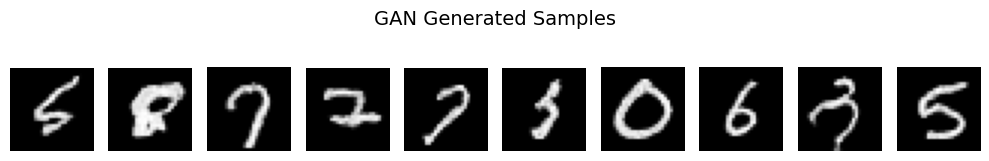

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_gan_samples(n=10):
    G_1.eval()

    z = torch.randn(n, G_1.z_dim, 1, 1, device=device)

    fake_imgs = G_1(z).cpu().numpy()  # (10,1,28,28)

    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    for i in range(n):
        axes[i].imshow(fake_imgs[i, 0], cmap="gray")
        axes[i].axis("off")

    # ✅ 設定大標題，置中顯示
    plt.suptitle("GAN Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

show_gan_samples()

# Conditional Generative Adversarial Network (cGAN) 邏輯流程

---

## 1. 問題背景
- **核心概念**：cGAN 在 GAN 的基礎上 **加入條件 (condition)**，例如類別標籤或屬性。  
  - **生成器 (Generator, G)**：不僅依靠隨機噪聲 $z$，還會輸入條件 $y$（如數字 0–9 的 one-hot 向量），生成對應的假樣本。  
  - **鑑別器 (Discriminator, D)**：除了輸入影像 $x$，也會接收條件 $y$，判斷樣本是否「在條件 $y$ 下是真實的」。  
- **效果**：可以控制生成的影像內容，例如指定要生成手寫數字 “7”。

---

## 2. 資料流與維度 (以 MNIST 28×28 為例)

### 生成器 G
- 輸入：
  - 隨機向量 $z \sim \mathcal{N}(0,I)$，形狀 $(B, z\_dim, 1, 1)$  
  - 條件向量 $y$，例如數字 0–9 的 one-hot，形狀 $(B, num\_classes)$  
- **整合方式：**
  - 常見作法：把 $z$ 與 $y$ 拼接後一起輸入生成器。  
- **輸出**：
  - 與 GAN 相同，經過反捲積得到影像 $(B,1,28,28)$  
  - 輸出經 Tanh 或 Sigmoid（取決於資料預處理範圍）

### 鑑別器 D
- 輸入：
  - 影像 $x$（真或假）  
  - 條件向量 $y$  
- **整合方式：**
  - 常見方法：將 $y$ 擴張成與 $x$ 相同大小的 feature map，與影像在 channel 維度拼接。  
  - 例如 $y$ → $(B,num\_classes,28,28)$，與 $x$ 拼接成 $(B,1+num\_classes,28,28)$  
- **輸出**：
  - 單一機率值 $\in [0,1]$，代表「在條件 $y$ 下，該影像是否真實」。

---

## 3. 損失函數 (對抗式目標)

### 對鑑別器 D
- 希望對「真樣本 + 條件 $y$」輸出 1；  
- 對「假樣本 + 條件 $y$」輸出 0。  
- 損失：
  $$
  L_D = -\frac{1}{2}\Big[ \log D(x_{real}, y) + \log(1 - D(x_{fake}, y)) \Big]
  $$

### 對生成器 G
- 希望「假樣本 + 條件 $y$」能騙過 D → 輸出接近 1。  
- 損失：
  $$
  L_G = - \log D(x_{fake}, y)
  $$

---

## 4. 訓練步驟（每個 batch）
- **訓練 D**
  - 從資料集中取一批真樣本 $x_{real}$，及其標籤 $y$，標籤設為 1。  
  - 用 G 生成一批假樣本 $x_{fake}$，搭配相同條件 $y$，標籤設為 0。  
  - 用 BCE Loss 分別計算誤差，更新 D。  
- **訓練 G**
  - 取一批隨機噪聲 $z$ 和條件 $y$，生成假樣本 $x_{fake}$。  
  - 餵進 D，期望 D 的輸出接近 1。  
  - 用 BCE Loss 更新 G。  

---

## 5. 程式碼對應 (核心對照)
- **Generator 類別** → 接收 $(z,y)$，經拼接後生成影像。  
- **Discriminator 類別** → 接收 $(x,y)$，在 channel 維度拼接，輸出真偽機率。  
- **optG / optD** → Adam 最佳化器，與 GAN 相同。  
- **criterion** →
  - `nn.BCELoss()`（需 Sigmoid 輸出）  
  - 或 `nn.BCEWithLogitsLoss()`（直接輸出 logit 更穩定）  
- **訓練流程**：
  - `lossD_real = criterion(D(x_real, y), label_real)`  
  - `lossD_fake = criterion(D(x_fake.detach(), y), label_fake)`  
  - `lossG = criterion(D(x_fake, y), label_real)`  

---

## 6. 訓練觀察
- **LossD**
  - 太低 → D 太強，G 學不到東西。  
  - 太高 → D 太弱，G 輕易騙過，可能 collapse。  
- **LossG**
  - 太高 → G 生成不真實。  
  - 適中 → G 與 D 拉鋸，對抗健康。  
- **常見技巧**
  - **Label smoothing**：對真樣本標籤用 0.9 取代 1，避免 D 過強。  
  - **條件嵌入 (embedding)**：將 $y$ 經嵌入層後再拼接，能更穩定學習。  
  - **固定 latent 向量 + 固定條件**：每個 epoch 用同一組 $(z,y)$，方便觀察不同條件下的生成效果。  

---

## 7. GAN vs cGAN 差異對照表

| 項目 | GAN | cGAN |
|------|-----|------|
| **輸入 (G)** | 噪聲向量 $z$ | 噪聲向量 $z$ + 條件 $y$ |
| **輸入 (D)** | 影像 $x$ | 影像 $x$ + 條件 $y$ |
| **能否控制生成內容** | ❌ 無法控制，隨機生成 | ✅ 可控，依條件生成特定類別或特徵 |
| **應用範例** | 任意圖像生成 | 手寫數字分類生成、人臉屬性生成 (如戴眼鏡/不戴眼鏡)、文本到圖像生成 |
| **損失函數** | $\log D(x)$ 與 $\log (1-D(G(z)))$ | $\log D(x,y)$ 與 $\log (1-D(G(z,y),y))$ |

---

## 8. 整體邏輯摘要
- **GAN 與 cGAN 的主要差異**在於是否加入條件：  
  - GAN → 無法控制生成的樣本內容。  
  - cGAN → 可以依據條件精確控制生成的樣本種類或屬性。  
- **最終目標**：在給定條件下，生成器能產生符合條件的真實樣本，讓鑑別器難以區分。


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# =============================
# 1. 定義 cGAN 模型
# =============================

class Generator(nn.Module):
    """
    條件生成器 (cG)：輸入 (z, y)，輸出符合條件 y 的圖片。
    - z: 隨機噪聲 (B, z_dim, 1, 1)
    - y: 條件標籤 (B,) → one-hot → (B, num_classes)
    """
    def __init__(self, z_dim=100, num_classes=10, img_channels=1):
        super().__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes

        # Embedding：將 y 轉換成 one-hot 向量
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # 輸入維度 = z_dim + num_classes
        self.net = nn.Sequential(
            # 輸入 latent vector (B, z_dim + num_classes, 1, 1) → (B,128,7,7)
            # kernel=7, stride=1, padding=0
            nn.ConvTranspose2d(z_dim + num_classes, 128, kernel_size=7, stride=1, padding=0, bias=False),
            # BatchNorm2d：標準化每個 batch 的特徵分布 → 訓練更穩定，加快收斂
            nn.BatchNorm2d(128),
            # ReLU：非線性激活，讓生成器能學習複雜映射，把噪聲轉換成影像特徵
            nn.ReLU(True),

            # (B,128,7,7) → (B,64,14,14)
            # kernel=4, stride=2, padding=1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # (B,64,14,14) → (B,1,28,28)
            # 輸出與 MNIST 圖片大小相同
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            # 將像素壓到 [0,1]（因為 MNIST 是 [0,1]），如果輸入資料是 [-1,1]，會改成 Tanh()
            nn.Sigmoid()
        )

    def forward(self, z, y):
        # y: (B,) → one-hot → (B, num_classes)
        y_onehot = self.label_emb(y)
        # 拼接：z 和 y 在 channel 維度合併 → (B, z_dim + num_classes, 1, 1)
        z = torch.cat([z, y_onehot.unsqueeze(2).unsqueeze(3)], dim=1)

        return self.net(z)


class Discriminator(nn.Module):
    """
    條件鑑別器 (cD)：輸入 (x, y)，判斷圖像是否「真實且符合條件 y」。
    - x: 輸入影像 (B,1,28,28)
    - y: 條件標籤 (B,)
    """
    def __init__(self, num_classes=10, img_channels=1):
        super().__init__()
        self.num_classes = num_classes

        # Embedding：將 y 轉成 one-hot → (B,num_classes)
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            # (B,1 + num_classes,28,28) → (B,64,14,14)
            nn.Conv2d(img_channels + num_classes, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # LeakyReLU：允許 x<0 時仍有微小梯度，避免 ReLU「死掉」，更適合判別器
            nn.LeakyReLU(0.2, inplace=True),

            # (B,64,14,14) → (B,128,7,7)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # BatchNorm2d：避免鑑別器因輸入差異太大而不穩
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,128,7,7) → (B,1,1,1)
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            # 輸出 ∈ [0,1]，代表「真實機率」
            nn.Sigmoid()
        )

    def forward(self, x, y):
        # y: (B,) → one-hot → (B,num_classes)
        y_onehot = self.label_emb(y)
        # 擴展到影像大小 (B,num_classes,28,28)
        y_map = y_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, 28, 28)
        # 拼接在 channel 維度 → (B,1 + num_classes,28,28)
        x = torch.cat([x, y_map], dim=1)

        # 壓平成 (B,) 向量，每張圖輸出一個數字
        return self.net(x).view(-1)


# =============================
# 2. 初始化模型與設定
# =============================

# MNIST 0~9，共 10 類
num_classes = 10

# z_dim latent 向量維度 (輸入生成器的噪聲大小)
# 建立 G 和 D
G_2 = Generator(z_dim=100, num_classes=num_classes).to(device)
D_2 = Discriminator(num_classes=num_classes).to(device)

# Adam：常見 GAN 最佳化器 (beta 設為 0.5, 0.999 避免震盪)
g_opt = optim.Adam(G_2.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = optim.Adam(D_2.parameters(), lr=2e-4, betas=(0.5, 0.999))

# 損失函數：BCE
criterion = nn.BCELoss()

os.makedirs("samples/cgan", exist_ok=True)


# =============================
# 3. 訓練流程
# =============================

def train_cgan(epochs=5):
    # 固定噪聲 & 標籤，用於每個 epoch 的觀察圖
    fixed_z = torch.randn(10, G_2.z_dim, 1, 1, device=device)
    fixed_y = torch.arange(0, 10, device=device)  # 0~9 各生成一張

    for epoch in range(1, epochs + 1):
        # 因為有 BatchNorm → 每個 epoch 都要重設。
        G_2.train()
        D_2.train()

        total_d_loss, total_g_loss = 0.0, 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            current_batch_size = x.size(0)
            real_labels = torch.ones(current_batch_size, device=device)   # 真實樣本標籤=1
            fake_labels = torch.zeros(current_batch_size, device=device)  # 假樣本標籤=0

            # --------- 訓練 D ---------
            # step1: 真實樣本 (x,y)
            d_loss_real = criterion(D_2(x, y), real_labels)

            # step2: 假樣本 (由 G 生成，detach 以免更新 G)
            z = torch.randn(current_batch_size, G_2.z_dim, 1, 1, device=device)
            fake = G_2(z, y)
            d_loss_fake = criterion(D_2(fake.detach(), y), fake_labels)

            # D 的總損失 = 真實 + 假 的平均
            d_loss = (d_loss_real + d_loss_fake) / 2

            # 典型訓練三步驟：清梯度 → 反傳 → 更新
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # --------- 訓練 G ---------
            # 希望 D(fake,y)=1 (騙過鑑別器)
            z = torch.randn(current_batch_size, G_2.z_dim, 1, 1, device=device)
            fake = G_2(z, y)
            g_loss = criterion(D_2(fake, y), real_labels)

            # 典型訓練三步驟：清梯度 → 反傳 → 更新
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            # 累加損失
            total_d_loss += d_loss.item() * current_batch_size
            total_g_loss += g_loss.item() * current_batch_size

        # 計算平均損失
        d_avg = total_d_loss / len(train_loader.dataset)
        g_avg = total_g_loss / len(train_loader.dataset)

        print(f"[cGAN] Epoch {epoch}, LossD={d_avg:.4f} | LossG={g_avg:.4f}")

        save_cgan_samples(epoch, fixed_z, fixed_y)


# =============================
# 4. 儲存生成樣本
# =============================

@torch.no_grad()
def save_cgan_samples(epoch, fixed_z, fixed_y):
    # 評估模式（關閉 dropout 等），與 no_grad() 一起讓推論更快
    G_2.eval()

    fake = G_2(fixed_z, fixed_y).cpu()

    save_image(fake, f"samples/cgan/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

    print(f"已儲存 samples/cgan/epoch_{epoch}.png")


# =============================
# 5. 執行訓練
# =============================

if __name__ == "__main__":
    train_cgan(epochs=EPOCHS)
    print("cGAN 訓練完成！")


[cGAN] Epoch 1, LossD=0.5734 | LossG=0.9805
已儲存 samples/cgan/epoch_1.png
[cGAN] Epoch 2, LossD=0.6389 | LossG=0.8333
已儲存 samples/cgan/epoch_2.png
[cGAN] Epoch 3, LossD=0.6493 | LossG=0.8114
已儲存 samples/cgan/epoch_3.png
[cGAN] Epoch 4, LossD=0.6688 | LossG=0.7914
已儲存 samples/cgan/epoch_4.png
[cGAN] Epoch 5, LossD=0.6767 | LossG=0.7721
已儲存 samples/cgan/epoch_5.png
[cGAN] Epoch 6, LossD=0.6816 | LossG=0.7641
已儲存 samples/cgan/epoch_6.png
[cGAN] Epoch 7, LossD=0.6837 | LossG=0.7538
已儲存 samples/cgan/epoch_7.png
[cGAN] Epoch 8, LossD=0.6862 | LossG=0.7472
已儲存 samples/cgan/epoch_8.png
[cGAN] Epoch 9, LossD=0.6874 | LossG=0.7527
已儲存 samples/cgan/epoch_9.png
[cGAN] Epoch 10, LossD=0.6882 | LossG=0.7459
已儲存 samples/cgan/epoch_10.png
[cGAN] Epoch 11, LossD=0.6892 | LossG=0.7400
已儲存 samples/cgan/epoch_11.png
[cGAN] Epoch 12, LossD=0.6894 | LossG=0.7372
已儲存 samples/cgan/epoch_12.png
[cGAN] Epoch 13, LossD=0.6901 | LossG=0.7372
已儲存 samples/cgan/epoch_13.png
[cGAN] Epoch 14, LossD=0.6907 | LossG=0.733

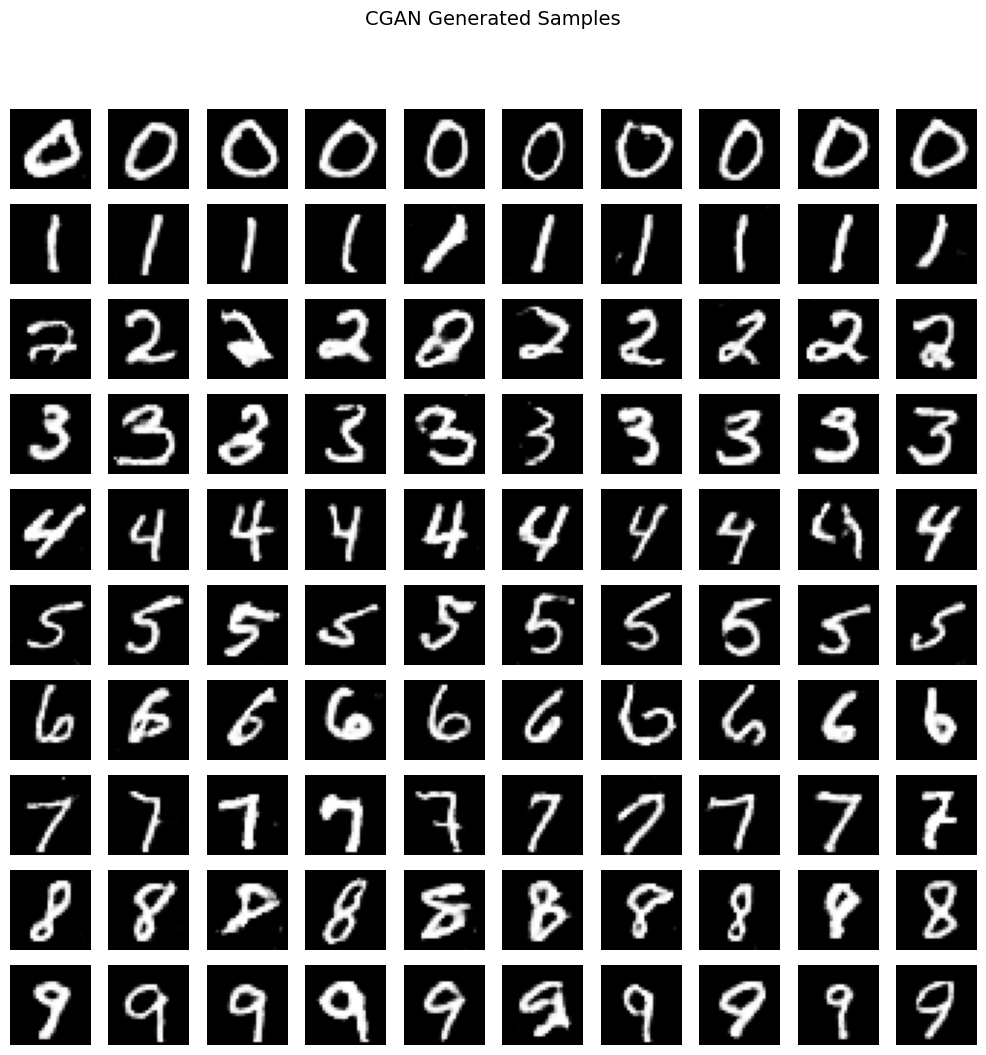

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_cgan_samples(n=10):
    G_2.eval()

    # 建立 10×10 的 label：每一列都是同一個數字
    labels = torch.arange(0, n, device=device).repeat_interleave(n)

    # 隨機噪聲
    z = torch.randn(n * n, G_2.z_dim, 1, 1, device=device)

    # 生成影像 (100,1,28,28)
    fake_imgs = G_2(z, labels).cpu().numpy()

    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    idx = 0
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(fake_imgs[idx, 0], cmap="gray")
            axes[i, j].axis("off")
            idx += 1

    # ✅ 設定大標題，置中顯示
    plt.suptitle("CGAN Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

show_cgan_samples()

# DDPM (Denoising Diffusion Probabilistic Model) with U-Net 邏輯流程

---

## 1. 問題背景
- **核心概念**：DDPM 是一種生成模型，透過「逐步加噪 → 學習去噪 → 逐步去噪生成」的過程，從純隨機高斯噪聲重建出真實影像。  
- **流程**：
  1. **Forward Diffusion**：對原始圖片 $x_0$ 在 $T$ 步內逐步加噪，得到 $x_t$，最後趨近於純噪聲。  
  2. **Reverse Diffusion**：用模型學習每一步的去噪，從 $x_T \sim \mathcal{N}(0,I)$ 逐步回到乾淨影像 $x_0$。  

---

## 2. 時間嵌入 (Sinusoidal Embedding)
- **問題**：模型只看到 $x_t$，但不知道「這張圖是第幾步」。  
- **解法**：把整數 $t$ 轉成一個高維向量 $t\_{emb}$，讓網路感知「噪聲程度」。  
- **公式**（維度 $d$）：  
  $$
  \text{PE}(t,2i) = \sin\!\Big(\frac{t}{10000^{2i/d}}\Big), \quad
  \text{PE}(t,2i+1) = \cos\!\Big(\frac{t}{10000^{2i/d}}\Big)
  $$  
- **直覺**：就像在每一步給模型一張「噪聲程度的名片」。

---

## 3. 卷積模塊 (Residual / Down / Up Block)

### 3.1 共同結構
1. **卷積 + BN + ReLU** 提取特徵。  
2. **時間調變**：  
   - 把 $t\_{emb}$ 經 MLP 投影到與通道數相同的維度。  
   - 加到 feature map 上（broadcast 到整張圖）：  
     $$
     h = h + W_t(t\_{emb})[:, :, None, None]
     $$
3. **卷積 + BN + ReLU** 再處理。  

👉 這一步讓「時間資訊」進入影像特徵，告訴網路「要去多少噪聲」。

### 3.2 Down Block
- 最後用 **Conv2d(stride=2)**，讓尺寸減半。  
- **公式**：  
  $$
  H_{out} = \Big\lfloor \frac{H_{in}+2p-k}{s}\Big\rfloor + 1
  $$  
  例如 $k=4,s=2,p=1$ → $28 \to 14$。  

### 3.3 Up Block
- 最後用 **ConvTranspose2d(stride=2)**，讓尺寸翻倍。  
- **公式**：  
  $$
  H_{out} = (H_{in}-1)\cdot s - 2p + k
  $$  
  例如 $k=4,s=2,p=1$ → $7 \to 14$。  

---

## 4. U-Net Backbone
- **編碼器 (Encoder)**：逐步下採樣 → 抽象出語義特徵。  
- **中間層 (Mid Block)**：保持尺寸不變 → 深度處理抽象語義。  
- **解碼器 (Decoder)**：逐步上採樣 → 重建影像解析度。  
- **Skip Connection**：在對應解析度把 Encoder 的特徵加回來，保留細節。  

👉 就像「先壓縮 → 處理 → 再還原」，並且在解壓時把細節補回來。

---

## 5. Forward Diffusion 公式
對於 timestep $t$：  
$$
x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon, \quad \epsilon \sim \mathcal{N}(0,I)
$$
其中：  
- $\beta_t$：每步加的噪聲比例（通常線性排程）。  
- $\alpha_t = 1-\beta_t$。  
- $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$（累積噪聲強度）。  

👉 我們可以直接從 $x_0$ 一步抽樣到 $x_t$，不用真的加噪 $t$ 次。

---

## 6. Reverse Diffusion 公式
在生成時，每一步要從 $x_t$ 推回 $x_{t-1}$：  
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\Big(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\,\epsilon_\theta(x_t,t)\Big) + \sigma_t z
$$
其中：  
- $\epsilon_\theta(x_t,t)$：模型預測噪聲。  
- $\sigma_t = \sqrt{\beta_t}$。  
- $z \sim \mathcal{N}(0,I)$，只在 $t>0$ 時加入 → 保留隨機性。  

👉 就像「一步一步擦掉雜訊，最後得到乾淨圖片」。

---

## 7. 損失函數
因為我們知道 forward 的真實噪聲 $\epsilon$，訓練目標就是：  
$$
\mathcal{L} = \mathbb{E}_{x_0,t,\epsilon}\big[\|\epsilon - \epsilon_\theta(x_t,t)\|^2\big]
$$
- 使用 **MSE Loss**，強迫模型正確預測噪聲。

---

## 8. 訓練流程（每個 batch）
1. 從資料集中取一張影像 $x_0$。  
2. 隨機選 timestep $t$。  
3. 用 forward 公式得到 $x_t$ 和真實噪聲 $\epsilon$。  
4. 模型輸入 $(x_t,t)$，輸出 $\epsilon_\theta$。  
5. 計算 MSE Loss，更新參數。  

---

## 9. 訓練觀察
- **Loss 曲線**：應該平滑下降。  
- **生成影像**：  
  - 初期 → 模糊斑塊。  
  - 中期 → 出現數字輪廓。  
  - 後期 → 清晰手寫數字。  
- **關鍵參數**：  
  - $T=1000$ → 越大越精細，但取樣更慢。  
  - 學習率 $lr=1e-4$ → 太高會發散，太低收斂慢。  
  - 通道數 `64-128-256` → 模型越深越寬，效果越好。  

---

## 10. 總結
- **時間嵌入**：把步數 $t$ 編成向量，提供「噪聲程度」訊息。  
- **Residual/Down/Up Block**：在卷積層中注入時間資訊，並做上下採樣。  
- **U-Net**：編碼壓縮 → 中間處理 → 解碼還原，跳接保細節。  
- **公式**：  
  - Forward → 加噪。  
  - Reverse → 去噪。  
- **最終目標**：學會「看圖說噪」，用這個能力從純噪聲生成清晰影像。  


In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image


# =============================
# 1. Sinusoidal Timestep Embedding
# =============================

def sinusoidal_embedding(t, dim):
    """
    把 timestep (0 ~ T-1) 編碼成高維向量。
    - 作用：讓模型知道「目前是第幾步」。
    - 公式：PE(t,2i)   = sin(t / 10000^(2i/dim))
            PE(t,2i+1) = cos(t / 10000^(2i/dim))
    - 類似 Transformer 的 Positional Encoding。
    """
    device = t.device
    half = dim // 2

    # 建立不同頻率的縮放因子 → 控制 sin/cos 的週期長度
    freq = torch.exp(torch.arange(half, device=device) * -(math.log(10000) / (half - 1)))  # (half,)

    # 計算每個 timestep t 在不同頻率下的角度
    angles = t[:, None] * freq[None, :]  # (B, half)

    # 拼接 sin/cos，得到 (B, dim)
    return torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)


# =============================
# 2. Residual Block (支援上/下採樣)
# =============================

class ResidualBlock(nn.Module):
    """
    基本卷積模塊，支援下採樣 (down=True) 或上採樣 (up=True)。
    每個 Block 都會接收 timestep embedding，讓模型知道「在第幾步去噪」。
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, down=False, up=False):
        super().__init__()
        assert not (down and up), "Block 不能同時 down 和 up"

        # 時間 embedding 維度對齊 → 映射成 out_channels
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        # 兩層 conv + BN + ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.act   = nn.ReLU(inplace=True)

        # 上/下採樣層
        if down:
            self.transform = nn.Conv2d(out_channels, out_channels, 4, stride=2, padding=1)   # H,W → H/2,W/2
        elif up:
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, stride=2, padding=1) # H,W → H*2,W*2
        else:
            self.transform = nn.Identity()  # 不變化

    def forward(self, x, t_emb):
        # 先卷積 + BN + ReLU
        h = self.act(self.bn1(self.conv1(x)))

        # 加入時間嵌入 → broadcast 成 (B,C,H,W)
        h = h + self.time_mlp(t_emb)[:, :, None, None]

        # 再一次 conv + BN + ReLU
        h = self.act(self.bn2(self.conv2(h)))

        # 視情況做上/下採樣
        return self.transform(h)


# =============================
# 3. U-Net Backbone
# =============================

class UNet(nn.Module):
    """
    標準 U-Net 結構：
    Encoder (下採樣) → Bottleneck → Decoder (上採樣)，
    並透過 Skip Connection 保留細節。
    """
    def __init__(self, img_channels=1, time_emb_dim=64):
        super().__init__()

        # timestep embedding 先經過一個小 MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(inplace=True)
        )

        # -------- Encoder (下採樣) --------
        self.conv0 = nn.Conv2d(img_channels, 64, 3, padding=1)             # (B,1,28,28) → (B,64,28,28)
        self.down1 = ResidualBlock(64, 128, time_emb_dim, down=True)       # (B,64,28,28) → (B,128,14,14)
        self.down2 = ResidualBlock(128, 256, time_emb_dim, down=True)      # (B,128,14,14) → (B,256,7,7)

        # -------- Bottleneck --------
        self.mid   = ResidualBlock(256, 256, time_emb_dim)                 # (B,256,7,7) → (B,256,7,7)

        # -------- Decoder (上採樣) --------
        self.up1   = ResidualBlock(256, 128, time_emb_dim, up=True)        # (B,256,7,7) → (B,128,14,14)
        self.up2   = ResidualBlock(128, 64,  time_emb_dim, up=True)        # (B,128,14,14) → (B,64,28,28)

        # -------- Output --------
        self.out   = nn.Conv2d(64, img_channels, kernel_size=1)            # (B,64,28,28) → (B,1,28,28)

    def forward(self, x, t):
        # Step 1: timestep embedding
        t_emb = self.time_mlp(sinusoidal_embedding(t, 64))   # (B,64)

        # Step 2: Encoder
        x0 = self.conv0(x)           # 第一層卷積
        x1 = self.down1(x0, t_emb)   # 下採樣 → (14x14)
        x2 = self.down2(x1, t_emb)   # 下採樣 → (7x7)

        # Step 3: Bottleneck
        m  = self.mid(x2, t_emb)     # 中間層 (不改大小)

        # Step 4: Decoder + Skip Connection
        u1 = self.up1(m, t_emb) + x1 # 上採樣後加回對應 encoder 特徵
        u2 = self.up2(u1, t_emb) + x0

        # Step 5: Output
        return self.out(u2)


# =============================
# 4. Diffusion (Forward + Reverse)
# =============================

class DDPM:
    """
    Diffusion 核心：
    - q_sample: 前向加噪 (x0 → xt)
    - p_sample: 反向去噪 (xt → xt-1)
    - sample  : 從純高斯噪聲生成圖片
    """
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.model = model
        self.device = device
        self.T = timesteps

        # 線性 β schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  # ᾱ_t

    def q_sample(self, x0, t):
        """
        前向過程 (加噪):
        x_t = sqrt(ᾱ_t) * x0 + sqrt(1-ᾱ_t) * noise
        """
        noise = torch.randn_like(x0)
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]

        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

    @torch.no_grad()
    def p_sample(self, x, t):
        """
        反向過程 (去噪一步):
        x_{t-1} = 1/sqrt(α_t) * (x_t - β_t/sqrt(1-ᾱ_t) * εθ) + σ_t * z
        """
        betas_t = self.betas[t]
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alpha_hat[t])
        sqrt_recip_alphas_t = torch.sqrt(1.0 / self.alphas[t])

        # 模型預測噪聲
        pred_noise = self.model(x, torch.tensor([t], device=self.device).repeat(x.size(0)))

        # 計算 mean
        mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alpha_hat_t * pred_noise)

        if t == 0:
            return mean
        return mean + torch.sqrt(betas_t) * torch.randn_like(x)

    @torch.no_grad()
    def sample(self, n=10):
        """
        從純高斯噪聲逐步去噪生成圖片
        """
        x = torch.randn(n, 1, 28, 28, device=self.device)   # 從 N(0,I) 開始
        for t in range(self.T - 1, -1, -1):                 # 逐步去噪
            x = self.p_sample(x, t)

        return x


# =============================
# 5. 訓練流程
# =============================

def train_ddpm(ddpm, train_loader, epochs=5, lr=1e-4, save_dir="samples/diffusion"):
    os.makedirs(save_dir, exist_ok=True)
    model, device = ddpm.model, ddpm.device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for x, _ in train_loader:
            x = x.to(device)
            bsz = x.size(0)

            # Step 1: 隨機 timestep
            t = torch.randint(0, ddpm.T, (bsz,), device=device).long()

            # Step 2: 前向加噪
            x_t, noise = ddpm.q_sample(x, t)

            # Step 3: 模型預測噪聲
            pred_noise = model(x_t, t)

            # Step 4: 損失 = 預測噪聲 vs 真實噪聲
            loss = criterion(pred_noise, noise)

            # Step 5: 更新參數
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * bsz

        # 平均 loss
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[DDPM] Epoch {epoch}, Loss={avg_loss:.4f}")

        # 儲存生成樣本
        samples = ddpm.sample(n=10)
        save_image(samples, f"{save_dir}/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

        print(f"已儲存 samples/diffusion/epoch_{epoch}.png")


# =============================
# 6. 主程式
# =============================

model = UNet().to(device)
ddpm = DDPM(model, timesteps=1000, device=device)

if __name__ == "__main__":
    train_ddpm(ddpm, train_loader, epochs=EPOCHS)
    print("DDPM 訓練完成！")


[DDPM] Epoch 1, Loss=0.1283
已儲存 samples/diffusion/epoch_1.png
[DDPM] Epoch 2, Loss=0.0381
已儲存 samples/diffusion/epoch_2.png
[DDPM] Epoch 3, Loss=0.0319
已儲存 samples/diffusion/epoch_3.png
[DDPM] Epoch 4, Loss=0.0289
已儲存 samples/diffusion/epoch_4.png
[DDPM] Epoch 5, Loss=0.0269
已儲存 samples/diffusion/epoch_5.png
[DDPM] Epoch 6, Loss=0.0254
已儲存 samples/diffusion/epoch_6.png
[DDPM] Epoch 7, Loss=0.0241
已儲存 samples/diffusion/epoch_7.png
[DDPM] Epoch 8, Loss=0.0233
已儲存 samples/diffusion/epoch_8.png
[DDPM] Epoch 9, Loss=0.0224
已儲存 samples/diffusion/epoch_9.png
[DDPM] Epoch 10, Loss=0.0221
已儲存 samples/diffusion/epoch_10.png
[DDPM] Epoch 11, Loss=0.0215
已儲存 samples/diffusion/epoch_11.png
[DDPM] Epoch 12, Loss=0.0212
已儲存 samples/diffusion/epoch_12.png
[DDPM] Epoch 13, Loss=0.0206
已儲存 samples/diffusion/epoch_13.png
[DDPM] Epoch 14, Loss=0.0200
已儲存 samples/diffusion/epoch_14.png
[DDPM] Epoch 15, Loss=0.0200
已儲存 samples/diffusion/epoch_15.png
[DDPM] Epoch 16, Loss=0.0196
已儲存 samples/diffusion/epoch_1

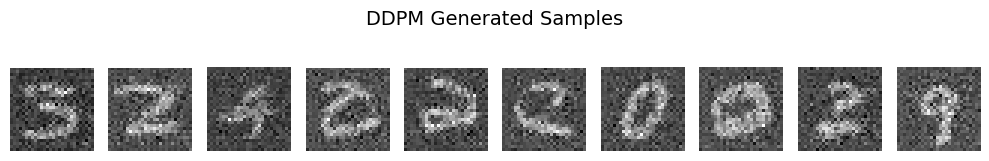

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_diffusion_samples(n=10):
    ddpm.model.eval()
    samples = ddpm.sample(n=n).cpu()  # (n,1,28,28)

    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    for i in range(n):
        img = samples[i, 0]

        # 跟 save_image 一樣做正規化
        img = (img - img.min()) / (img.max() - img.min())

        # 禁止模糊插值 → 保持像素銳利
        axes[i].imshow(img, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
        axes[i].axis("off")

    plt.suptitle("DDPM Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

show_diffusion_samples()

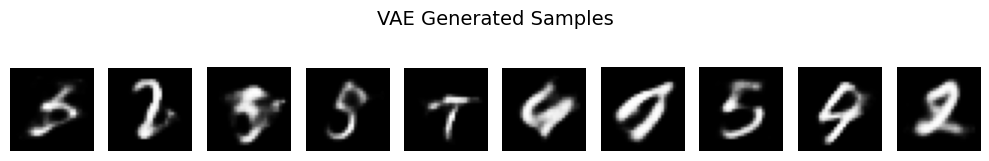

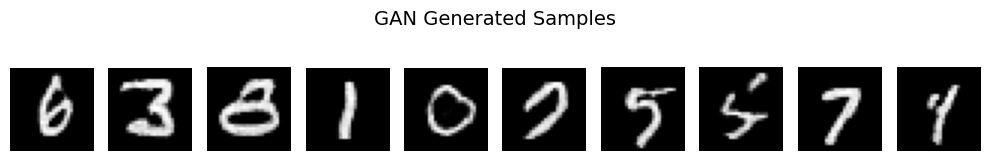

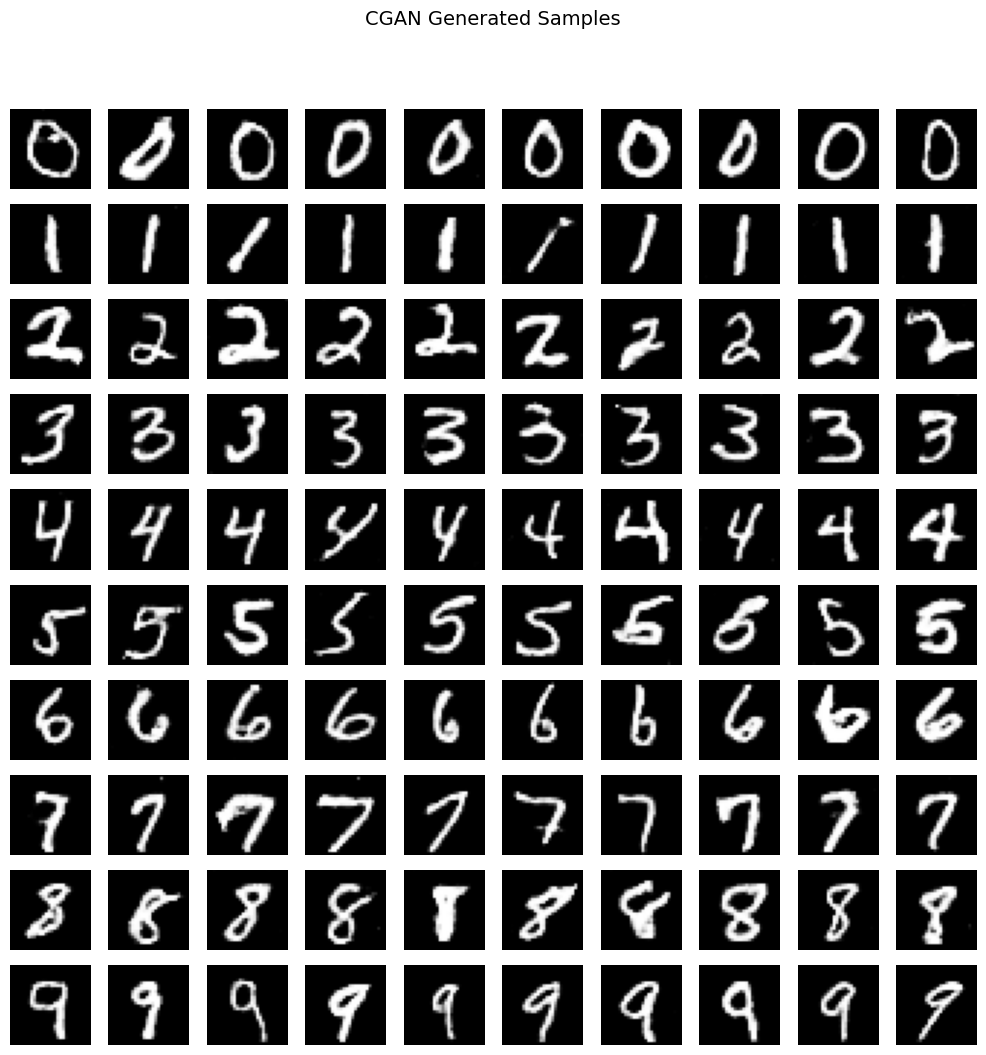

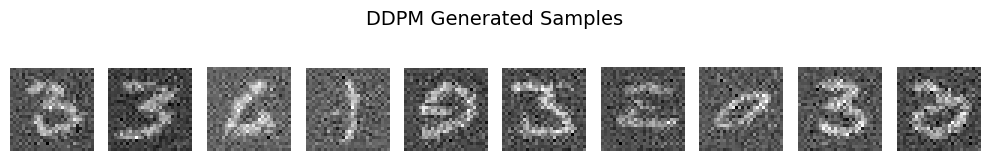

In [ ]:
show_vae_samples()
show_gan_samples()
show_cgan_samples()
show_diffusion_samples()